# KUSV offline route generation

## Author
Kichun Jo | kichun@konkuk.ac.kr | 2019-08-15 Creation

## Objective
Smooth route generation for KUSV test and simualtion

## Software procedure
1. Configuration and import
2. Import OSM file
    - import osm file
    - filtering data
3. Route generation with B-spline interpolation
    - Coordinate conversion (WGS84 -> ENU)
    - B-spline interpolation
    - Coordinate conversion (ENU -> WGS84)
4. Export OSM file
    - export osm file


## 1. Configuration and import

### Import

In [1]:
# System
import sys

# date time
from datetime import datetime

# Dialogs
import tkinter as tk
from tkinter import filedialog

# XML 
import xml.etree.ElementTree as ET

# Numerical operations
import numpy as np
import scipy.interpolate as inter
from scipy.ndimage.filters import gaussian_filter

# Plot
import matplotlib
import matplotlib.pyplot as plt

### Configuration
Change the configuration of SW, such as debugging option, smoothing option, and expoer option. 

In [2]:
# 1. Import OSM
bCfg_ImportDebug = True # debug info. on/off


# 2. Smoothing 
bCfg_SmoothingDebug = True # debug info. on/off

cfg_geometry_smoothing_max_tolerance = 0.1
tmp_max_tolerance = input("What's the maximum tolerance (default = 0.1) from raw geometry to smoothing geometry? ")
if tmp_max_tolerance != '':
    try:
        cfg_geometry_smoothing_max_tolerance = float(tmp_max_tolerance)
    except:        
        print('cfg_geometry_smoothing_max_tolerance = 0.1')
else:
    print('default: cfg_geometry_smoothing_max_tolerance = 0.1')

cfg_geometry_smoothing_improve_rate = 0.1 # [0 1]

cfg_route_resample_dist = 0.3
tmp_tmp_kernel_size = input("What's the resampling distance? ")
if tmp_tmp_kernel_size != '':
    try:
        cfg_route_resample_dist = float(tmp_tmp_kernel_size)
    except:        
        print('tmp_tmp_kernel_size = ', cfg_route_resample_dist)
else:
    print('default: tmp_kernel_size = ', cfg_route_resample_dist)
    

# 3. Export OSM
bCfg_ExportDebug = True # debug info. on/off
bCfg_is_export_heading_curvature_info = True

What's the maximum tolerance (default = 0.1) from raw geometry to smoothing geometry? 0.1
What's the resampling distance? 0.1


## 2. Import OSM file

### Import and export folder configuration

In [3]:
# Input output folder path
InputOsmPath = ''
root_tk = tk.Tk()
root_tk.withdraw()

InputOsmPath = filedialog.askopenfilename(filetypes =(("osm File", "*.osm"),("All Files","*.*")),
                                          title = "Choose a file."
                                          )
if InputOsmPath == '':
    sys.exit("[1. OSM Import] No import file!")

# Output folder path
cuurent_date_time = datetime.now() # current date and time
str_cuurent_date_time = cuurent_date_time.strftime("%Y%d%m_%H%M%S")

OutputOsmPath = ''
if InputOsmPath.endswith('.osm'):
    OutputOsmPath = InputOsmPath.replace('.osm','_' + str_cuurent_date_time + '_route_gen.osm')
else:
    OutputOsmPath = [InputOsmPath,'_'+str_cuurent_date_time+'_route_gen.osm']

# Debug display
if bCfg_ImportDebug:
    print('[1. OSM Import] Import file: ', InputOsmPath)
    print('[1. OSM Import] Expected Export file: ', OutputOsmPath)

('[1. OSM Import] Import file: ', '/home/lke/SK-Autopilot/src/setpoint/osmfiles/konkuk_wp.osm')
('[1. OSM Import] Expected Export file: ', '/home/lke/SK-Autopilot/src/setpoint/osmfiles/konkuk_wp_20191810_124227_route_gen.osm')


### Parse osm xml file

In [4]:
# Parse osm xml file
if bCfg_ImportDebug:
    print('[1. OSM Import] Import xml file')

tree_import = ET.parse(InputOsmPath)
root_import = tree_import.getroot()

[1. OSM Import] Import xml file


### Filtering and error check

In [5]:
# Filtering and error check
if bCfg_ImportDebug:
    print('[1. OSM Import] Filtering and error check')

NumOfNode = 0
NumOfWay = 0
NumOfDelElement = 0

for element_1st in root_import:
    # Counting
    if element_1st.tag == 'node':
        NumOfNode = NumOfNode + 1
    elif element_1st.tag == 'way':
        NumOfWay = NumOfWay + 1          
        
    # Get child attributes
    strActionValue = element_1st.attrib.get('action')
    
    # Delete the attributes of actions
    if strActionValue != None:
        del element_1st.attrib['action']
        NumOfDelElement = NumOfDelElement + 1
        
    # Delete the element with action = delete
    if strActionValue=='delete':
        root_import.remove(element_1st)
        if bCfg_ImportDebug == True:
            print(element_1st.tag, element_1st.attrib, ' are deleted') 

# Debug display
if bCfg_ImportDebug == True:
    print('NumOfNode: ', NumOfNode)
    print('NumOfWay: ', NumOfWay)
    print('NumOfDelElement: ', NumOfDelElement)

if NumOfWay > 1 and NumOfNode <= 2:
    sys.exit("[1. OSM Import] This version cannot handle multiple way osm!")

[1. OSM Import] Filtering and error check
('NumOfNode: ', 30)
('NumOfWay: ', 1)
('NumOfDelElement: ', 31)


### Construction of Node dictionary

In [6]:
# Construction of Node dictionary
if bCfg_ImportDebug:
    print('[1. OSM Import] Construction of node dictionary and way list')

DictNodes = dict()
for node_element in root_import.iter('node'):
    tmp_node_id = node_element.attrib['id']
    tmp_node_lat = node_element.attrib['lat']
    tmp_node_lon = node_element.attrib['lon']    
    DictNodes[tmp_node_id]=[tmp_node_lat, tmp_node_lon]

# Construction of lists for calculation
ListLatLon = []
for way_element in root_import.iter('way'):
    for nodes_in_way in way_element.iter('nd'):        
        tmp_node_in_way_attrib_ref = DictNodes[nodes_in_way.attrib['ref']]
        ListLatLon.append([float(tmp_node_in_way_attrib_ref[0]), float(tmp_node_in_way_attrib_ref[1])])  

[1. OSM Import] Construction of node dictionary and way list


## 3. Route generation with B-spline interpolation

### Functions of coorindate conversion

In [7]:
# Functions of coorindate conversion
def lengthOfDegreeLatitude(ref_latitude_deg):
    # Convert latitude to radians
    ref_latitude_rad = float(ref_latitude_deg) * np.pi / 180.

    # Set up "Constants"
    m1 = 111132.92 # Latitude calculation term 1
    m2 = -559.82 # Latitude calculation term 2
    m3 = 1.175 # Latitude calculation term 3
    m4 = -0.0023 # Latitude calculation term 4

    # Calculate the length of a degree of latitude and longitude in meters
    return m1 + (m2 * np.cos(2 * ref_latitude_rad)) 
    + (m3 * np.cos(4 * ref_latitude_rad))
    + (m4 * np.cos(6 * ref_latitude_rad))

def lengthOfDegreeLongitude(ref_latitude_deg):
    # Convert latitude to radians
    ref_latitude_rad = float(ref_latitude_deg) * np.pi / 180.

    # Set up "Constants"
    p1 = 111412.84 # Longitude calculation term 1
    p2 = -93.5 # Longitude calculation term 2
    p3 = 0.118 # Longitude calculation term 3

    # Calculate the length of a degree of latitude and longitude in meters
    return (p1 * np.cos(ref_latitude_rad)) 
    + (p2 * np.cos(3 * ref_latitude_rad))
    + (p3 * np.cos(5 * ref_latitude_rad))
    
def wgs84ToCartesian( geopoint_ref, geopoint ):
    # geopoint_ref: [latitude, longitude] list for origin points
    # geopoint: [latitude, longitude] list
    # return: [east, north]
    east = (geopoint[1] - geopoint_ref[1])*lengthOfDegreeLongitude(geopoint_ref[0])
    north = (geopoint[0] - geopoint_ref[0])*lengthOfDegreeLatitude(geopoint_ref[0])
    return [east, north]

def cartesianToWgs84( geopoint_ref, enupoint ):
    # geopoint_ref: [latitude, longitude] list for origin points
    # enupoint: [east, north] list        
    latitude = geopoint_ref[0] + enupoint[1]/lengthOfDegreeLatitude(geopoint_ref[0])
    longitude = geopoint_ref[1] + enupoint[0]/lengthOfDegreeLongitude(geopoint_ref[0])
    return [latitude, longitude]

### Coordinate conversion (WGS84 -> ENU)

In [8]:
# Coordinate conversion (WGS84 -> ENU)
if bCfg_SmoothingDebug:
    print('[2. Smoothing] Coordinate conversion (WGS84 -> ENU)')
    
ListEastNorth = list(ListLatLon)
RefLatLon = ListLatLon[0]
for index, iterLatLon in enumerate(ListLatLon):
    ListEastNorth[index] = wgs84ToCartesian(RefLatLon,iterLatLon)

[2. Smoothing] Coordinate conversion (WGS84 -> ENU)


### Numpy array conversion

In [9]:
# Numpy array conversion    
if bCfg_SmoothingDebug:
    print('[2. Smoothing] Construction of node dictionary and way np array')

arrayEastNorth = np.asarray(ListEastNorth, dtype=np.float64)

[2. Smoothing] Construction of node dictionary and way np array


### Arc-length calculation

In [10]:
# Arc-length calculation
if bCfg_SmoothingDebug:
    print('[2. Smoothing] Arc length calculation')

arrayArclength = np.zeros(arrayEastNorth.shape[0])
arrayDiffEastNorthSquare = np.diff(arrayEastNorth, n=1, axis=0)**2
arrayDistance = np.sqrt(np.sum(arrayDiffEastNorthSquare, axis=1))
arrayCumDistance = np.cumsum(arrayDistance)
arrayArclength[1:] = arrayCumDistance[:]

# Arc length array resampling
arrayResampleArclength = np.arange(arrayArclength[0], arrayArclength[-1], cfg_route_resample_dist)

[2. Smoothing] Arc length calculation


### Route approximation based on incremental univariateSpline

In [11]:
# Route smoothing based on univariateSpline
if bCfg_SmoothingDebug:
    print('[2. Smoothing] Route approximation based on incremental univariateSpline')

# Spline generation
avg_tolerance = cfg_geometry_smoothing_max_tolerance
smoothParam = avg_tolerance**2*len(arrayArclength)
splineSmoothEast = inter.UnivariateSpline (arrayArclength, arrayEastNorth[:,0], s=smoothParam)
splineSmoothNorth = inter.UnivariateSpline (arrayArclength, arrayEastNorth[:,1], s=smoothParam)
    
# Iterative error evaluation and correction
arraySmoothEastNorth = np.zeros(arrayEastNorth.shape)
arraySmoothEastNorth[:,0] = splineSmoothEast(arrayArclength)
arraySmoothEastNorth[:,1] = splineSmoothNorth(arrayArclength)
arrayDistanceError = np.sqrt(np.sum((arrayEastNorth - arraySmoothEastNorth)**2, axis=1))
maxDistError = np.max(arrayDistanceError)
maxDistErrorIdx = np.argmax(arrayDistanceError)
if bCfg_SmoothingDebug:
    print('Max Distance Error: ', maxDistError)

while maxDistError > cfg_geometry_smoothing_max_tolerance:    
    avg_tolerance = avg_tolerance * (1. - cfg_geometry_smoothing_improve_rate)    
    smoothParam = avg_tolerance**2*len(arrayArclength)

    splineSmoothEast = inter.UnivariateSpline (arrayArclength, arrayEastNorth[:,0], s=smoothParam)
    splineSmoothNorth = inter.UnivariateSpline (arrayArclength, arrayEastNorth[:,1], s=smoothParam)

    arraySmoothEastNorth = np.zeros(arrayEastNorth.shape)
    arraySmoothEastNorth[:,0] = splineSmoothEast(arrayArclength)
    arraySmoothEastNorth[:,1] = splineSmoothNorth(arrayArclength)
    arrayDistanceError = np.sqrt(np.sum((arrayEastNorth - arraySmoothEastNorth)**2, axis=1))
    maxDistError = np.max(arrayDistanceError)
    maxDistErrorIdx = np.argmax(arrayDistanceError)
    if bCfg_SmoothingDebug:
        print('Max Distance Error: ', maxDistError)

if bCfg_SmoothingDebug:
    print('Average tolerance: ', avg_tolerance)

# Knots
arrayKnotsEast = splineSmoothEast.get_knots()
arrayKnotsNorth = splineSmoothNorth.get_knots()

# Spline derivetive
splineSmoothEastDer1 = splineSmoothEast.derivative(1)
splineSmoothNorthDer1 = splineSmoothNorth.derivative(1)
splineSmoothEastDer2 = splineSmoothEast.derivative(2)
splineSmoothNorthDer2 = splineSmoothNorth.derivative(2)

[2. Smoothing] Route approximation based on incremental univariateSpline
('Max Distance Error: ', 0.29293468075211343)
('Max Distance Error: ', 0.2838255600843352)
('Max Distance Error: ', 0.27161007721345803)
('Max Distance Error: ', 0.19235405813749612)
('Max Distance Error: ', 0.16716855110481116)
('Max Distance Error: ', 0.16684842342600026)
('Max Distance Error: ', 0.1734038538944178)
('Max Distance Error: ', 0.11003371662070613)
('Max Distance Error: ', 0.11561908561696382)
('Max Distance Error: ', 0.11610620283004605)
('Max Distance Error: ', 0.11451029225483961)
('Max Distance Error: ', 0.1143174206236421)
('Max Distance Error: ', 0.08253245689781585)
('Average tolerance: ', 0.028242953648100012)


### Resampling

In [12]:
# Resampling
if bCfg_SmoothingDebug:
    print('[2. Smoothing] Resampling')

arrayResampleEastNorth = np.zeros([len(arrayResampleArclength), 2])
arrayResampleEastNorth[:,0] = splineSmoothEast(arrayResampleArclength)
arrayResampleEastNorth[:,1] = splineSmoothNorth(arrayResampleArclength)

arrayResampleEastNorthDer1 = np.zeros(arrayResampleEastNorth.shape)
arrayResampleEastNorthDer1[:,0] = splineSmoothEastDer1(arrayResampleArclength)
arrayResampleEastNorthDer1[:,1] = splineSmoothNorthDer1(arrayResampleArclength)

arrayResampleEastNorthDer2 = np.zeros(arrayResampleEastNorth.shape)
arrayResampleEastNorthDer2[:,0] = splineSmoothEastDer2(arrayResampleArclength)
arrayResampleEastNorthDer2[:,1] = splineSmoothNorthDer2(arrayResampleArclength)

# Smoothed Heading
arrayResampleHeading = np.arctan2( arrayResampleEastNorthDer1[:,1], arrayResampleEastNorthDer1[:,0]) * 180. / np.pi - 90.
arrayResampleHeading[arrayResampleHeading < 0] = arrayResampleHeading[arrayResampleHeading < 0] + 360.
arrayResampleHeading[arrayResampleHeading > 360] = arrayResampleHeading[arrayResampleHeading > 360] - 360.

# Smoothed Curvature
arrayCurNumerator = arrayResampleEastNorthDer1[:,0]*arrayResampleEastNorthDer2[:,1] - arrayResampleEastNorthDer1[:,1]*arrayResampleEastNorthDer2[:,0]
arrayCurDenominator = (arrayResampleEastNorthDer1[:,0]**2 + arrayResampleEastNorthDer1[:,1]**2)**1.5
arrayResampleCurvature = arrayCurNumerator / arrayCurDenominator

[2. Smoothing] Resampling


### Smoothing and resampling results

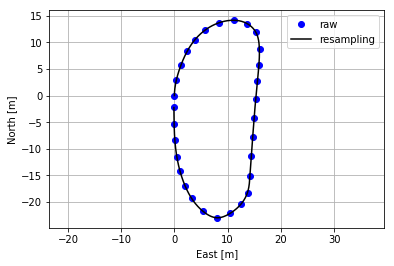

In [13]:
# Analysis - Shape
if bCfg_SmoothingDebug == True:
    fig = plt.figure()
    ax = fig.gca()
    
    plt.plot (arrayEastNorth[:,0], arrayEastNorth[:,1], 'bo', label='raw')
    plt.plot (arrayResampleEastNorth[:,0], arrayResampleEastNorth[:,1], 'k-', label='resampling')
    plt.legend()
    
    plt.axis('equal')
    plt.grid(True)
    
    plt.xlabel('East [m]')
    plt.ylabel('North [m]')
    
    plt.show()    

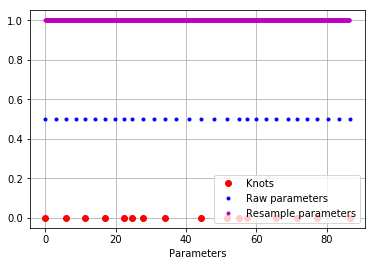

In [14]:
# Analysis - Distance to raw data
if bCfg_SmoothingDebug == True:
    fig = plt.figure()
    ax = fig.gca()
    
    plt.plot(arrayKnotsEast, arrayKnotsEast*0, 'ro', label='Knots')
    plt.plot(arrayArclength, arrayArclength*0+0.5, 'b.', label='Raw parameters')
    plt.plot(arrayResampleArclength, arrayResampleArclength*0+1, 'm.', label='Resample parameters')

    plt.legend()
    
    plt.grid(True)
    
    plt.xlabel('Parameters')    
    
    plt.show()

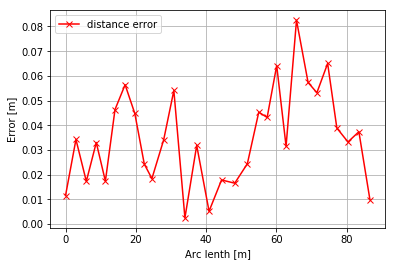

In [15]:
# Analysis - Distance to raw data
if bCfg_SmoothingDebug == True:
    fig = plt.figure()
    ax = fig.gca()
    
    plt.plot (arrayArclength, arrayDistanceError, 'rx-', label='distance error')    
    plt.legend()
    
    plt.grid(True)
    
    plt.xlabel('Arc lenth [m]')
    plt.ylabel('Error [m]')
    
    plt.show()

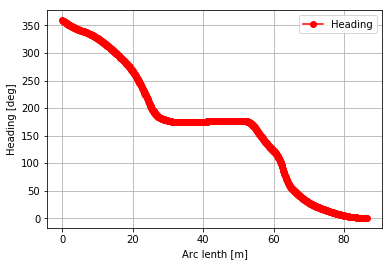

In [16]:
# Analysis - Heading
if bCfg_SmoothingDebug == True:
    fig = plt.figure()
    ax = fig.gca()
    
    plt.plot (arrayResampleArclength, arrayResampleHeading, 'ro-', label='Heading')        
    
    plt.legend()
    
    plt.grid(True)
    
    plt.xlabel('Arc lenth [m]')
    plt.ylabel('Heading [deg]')
    
    plt.show()


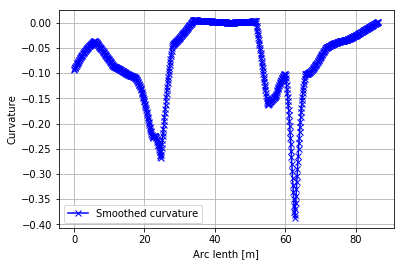

In [17]:
# Analysis - Curvature
if bCfg_SmoothingDebug == True:
    fig = plt.figure()
    ax = fig.gca()
        
    plt.plot (arrayResampleArclength, arrayResampleCurvature, 'bx-', label='Smoothed curvature')    
    
    plt.legend()
    
    plt.grid(True)
    
    plt.xlabel('Arc lenth [m]')
    plt.ylabel('Curvature')
    
    plt.show()

## 4. Export OSM file

### Numpy array conversion    

In [18]:
# Numpy array conversion    
if bCfg_ExportDebug:
    print('[3. Export] Construction of list from np array')

ListResampleEastNorth = arrayResampleEastNorth.tolist()
ListResampleHeading = arrayResampleHeading.tolist()
ListResampleCurvature = arrayResampleCurvature.tolist()

[3. Export] Construction of list from np array


### Coordinate conversion (ENU -> WGS84)

In [19]:
# Coordinate conversion (ENU -> WGS84)
if bCfg_ExportDebug:
    print('[3. Export] Coordinate conversion (ENU -> WGS84)')

RefLatLon = ListLatLon[0]
ListResampleLatLon = []
for iterResampleEastNorth in ListResampleEastNorth:
    ListResampleLatLon.append(cartesianToWgs84(RefLatLon,iterResampleEastNorth))

[3. Export] Coordinate conversion (ENU -> WGS84)


### Update routing results to xml

In [20]:
# Update smoothing results to xml
if bCfg_ExportDebug:
    print('[3. Export] Update smoothing results to xml')

root_export = ET.Element("osm")
root_export.set("version", "0.6")

# Node construction
for nodeID, nodeLatLon in enumerate(ListResampleLatLon):        
    nodeEle = ET.SubElement(root_export, "node", {"id": str(nodeID+1), "lat": str(nodeLatLon[0]), "lon" :str(nodeLatLon[1]), "version":"1"})    
    if bCfg_is_export_heading_curvature_info:
        ET.SubElement(nodeEle, "tag", {"k":"heading", "v":str(ListResampleHeading[nodeID])})
        ET.SubElement(nodeEle, "tag", {"k":"curvature", "v":str(ListResampleCurvature[nodeID])})    

# Way consruction
wayEle = ET.SubElement(root_export, "way", {"id": str(1), "version":"1"})    
for nodeID, nodeLatLon in enumerate(ListResampleLatLon):
    ET.SubElement(wayEle, "nd", {"ref":str(nodeID+1)})

[3. Export] Update smoothing results to xml


### Export osm file

In [21]:
# indent function
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i


# In[44]:

# Export smoothed osm file
if bCfg_ExportDebug:
    print('[3. Export] Export osm file')

indent(root_export)
tree_export = ET.ElementTree(root_export)    
tree_export.write(OutputOsmPath)
print('Complte smoothing! -', OutputOsmPath)

[3. Export] Export osm file
('Complte smoothing! -', '/home/lke/SK-Autopilot/src/setpoint/osmfiles/konkuk_wp_20191810_124227_route_gen.osm')
